In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

from src.models.tsvgp_white import t_SVGP_white
from src.models.tsvgp_cont import t_SVGP_cont, fixed_Z, piv_chol, pivoted_chol, OnlineGP
from src.models.tsvgp_cont import OnlineGP, t_SVGP_cont

from banana_utils import load_banana_dataset, plot_banana

In [2]:
plot_probability = True  # If False, plot variance, remeber to change vmin and vmax below accordingly
vmin  = 0
vmax = 1

num_inducing = 25
iterations = 100
num_mem = 5
lr = 0.01

fast_conditioning = False

In [3]:
train_x, train_y, test_x, test_y = load_banana_dataset()

# Make batches
ordering = np.argsort(train_x[:,0])

batch_1 = ordering[:100]
batch_2 = ordering[100:200]
batch_3 = ordering[200:300]
batch_4 = ordering[300:]

batches = [batch_1, batch_2, batch_3, batch_4]

In [4]:
train_x = tf.convert_to_tensor(train_x)
train_y = tf.convert_to_tensor(train_y)

In [5]:
xtest, ytest = np.mgrid[-2.8:2.8:100j, -2.8:2.8:100j]
Xtest = np.vstack((xtest.flatten(), ytest.flatten())).T
Xtest = Xtest.astype(np.float64)

## Full model t-SVGP

tf.Tensor(-397.63095168652217, shape=(), dtype=float64)


2023-06-16 10:57:42.778503: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-06-16 10:57:44.410350: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-06-16 10:57:44.411672: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor(-296.3848199188303, shape=(), dtype=float64)
tf.Tensor(-206.55066114149784, shape=(), dtype=float64)
tf.Tensor(-175.8049744741782, shape=(), dtype=float64)
tf.Tensor(-163.74103231138744, shape=(), dtype=float64)
tf.Tensor(-157.09353692642486, shape=(), dtype=float64)
tf.Tensor(-153.29068336682883, shape=(), dtype=float64)
tf.Tensor(-150.56671248705493, shape=(), dtype=float64)
tf.Tensor(-148.47543158449707, shape=(), dtype=float64)
tf.Tensor(-146.8428332034764, shape=(), dtype=float64)
tf.Tensor(-145.5370397560415, shape=(), dtype=float64)
tf.Tensor(-144.46165251262494, shape=(), dtype=float64)
tf.Tensor(-143.5480493041298, shape=(), dtype=float64)
tf.Tensor(-142.7437353598388, shape=(), dtype=float64)


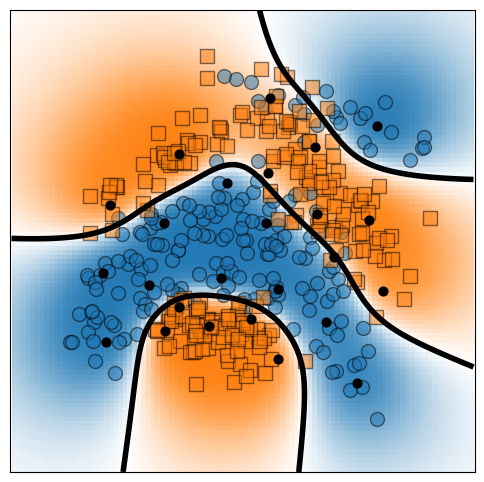

In [6]:
Z = train_x[:num_inducing, :]

optimizer = tf.optimizers.Adam(0.02)

m_full = t_SVGP_white(
    likelihood = gpflow.likelihoods.Bernoulli(),
    kernel = gpflow.kernels.Matern52(lengthscales=0.2),
    inducing_variable = Z,
)

training_loss = m_full.training_loss_closure((train_x, train_y[..., None]), compile=True)

print(m_full.elbo((train_x, train_y[..., None])))

for _ in range(250):
    m_full.natgrad_step((train_x, train_y[..., None]),lr = .2)
    optimizer.minimize(training_loss, var_list = m_full.trainable_variables)

    if _%20 == 1:
        print(m_full.elbo((train_x, train_y[..., None])))

Z_opt = m_full.inducing_variable.Z

pred_mu, pred_var = m_full.predict_y(Xtest)

data = (train_x.numpy(), train_y.numpy()[..., None])
inducing_pnts = Z_opt.numpy().copy()

plot_banana(pred_mu, pred_var, pred_mu, inducing_pnts, data, xtest, ytest, vmin=vmin, vmax=vmax, 
            plot_inducing=True, plot_probability=plot_probability)

## Streaming Dual GP

In [7]:
if fast_conditioning:
    m_cont = t_SVGP_cont(
        likelihood = gpflow.likelihoods.Bernoulli(),
        kernel=gpflow.kernels.Matern52(lengthscales=m_full.kernel.lengthscales.numpy(),
                                       variance=m_full.kernel.variance.numpy()),
        inducing_variable= Z_opt.numpy().copy(),
    )
else:        
    Z = tf.gather(train_x, batches[0])[:num_inducing, :].numpy().copy()
    m_cont = t_SVGP_cont(
        likelihood = gpflow.likelihoods.Bernoulli(),
        kernel=gpflow.kernels.Matern52(),
        inducing_variable= Z,
    )

gpflow.utilities.set_trainable(m_cont.inducing_variable.Z, False)

optimizer = tf.optimizers.Adam(lr)
new_data = (tf.gather(train_x, batches[0]), tf.gather(train_y, batches[0]))

if fast_conditioning:
    Z_picker = fixed_Z
else:
    Z_picker = piv_chol

m_online = OnlineGP(m_cont, opt_hypers=optimizer, n_steps=2, lambda_lr=1.0, Z_picker=Z_picker,
                   num_mem=num_mem)


In [8]:
def plot_z_mem(Z, mem, xtest, ytest, pred_mu):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.scatter(Z[:, 0], Z[:, 1], s=250, color='grey',  marker='+')
    ax.scatter(mem[:, 0], mem[:, 1], s=270, color='b', marker='*')
    
    ax.axis('equal')

    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    ax.set_xlim(-2.8, 2.8)
    ax.set_ylim(-2.8, 2.8)
    
    ax.contour(xtest, ytest, pred_mu.numpy().reshape(100, 100), levels=[.5],
               colors='k', linewidths=4.)
    plt.show()


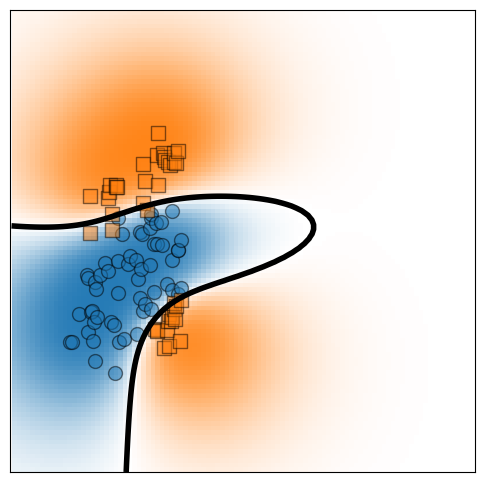

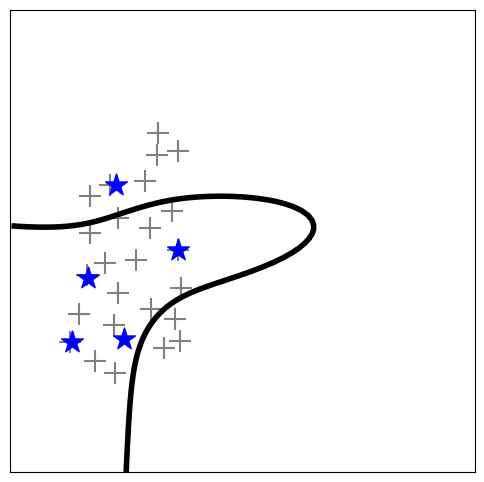

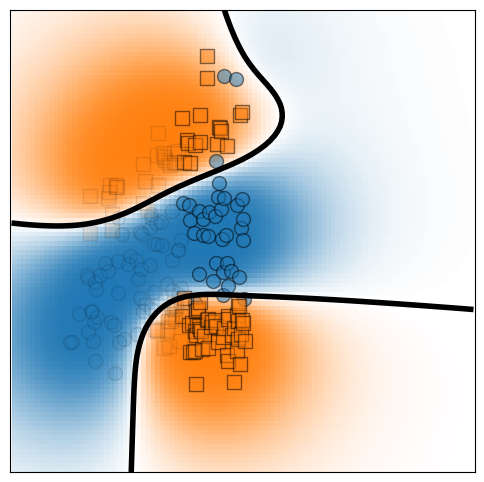

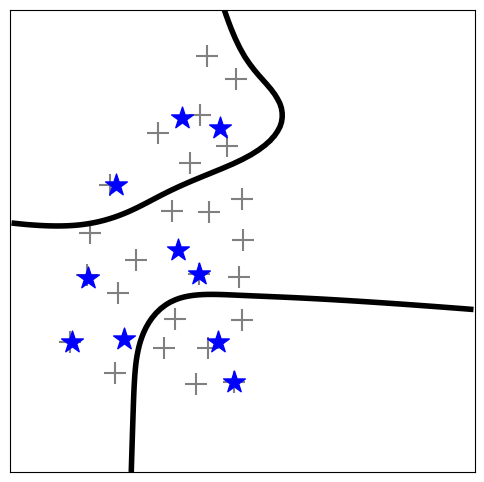

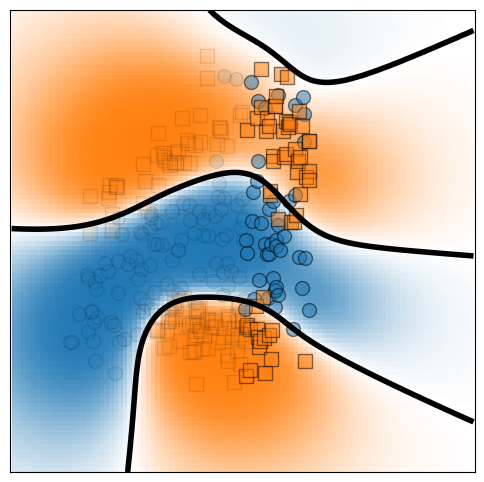

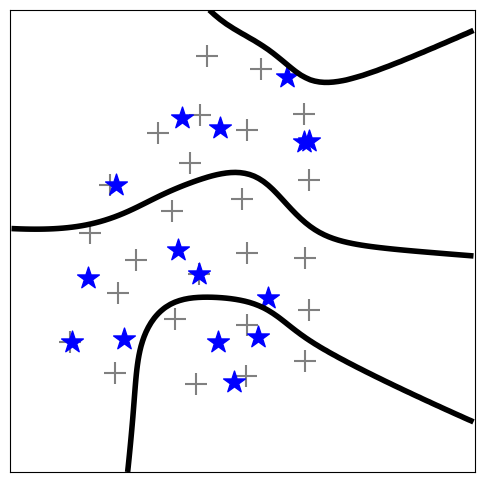

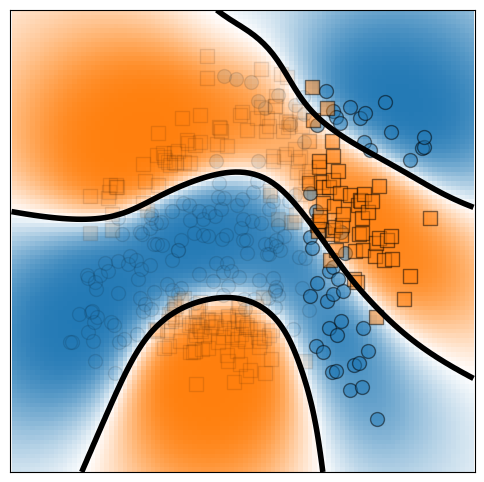

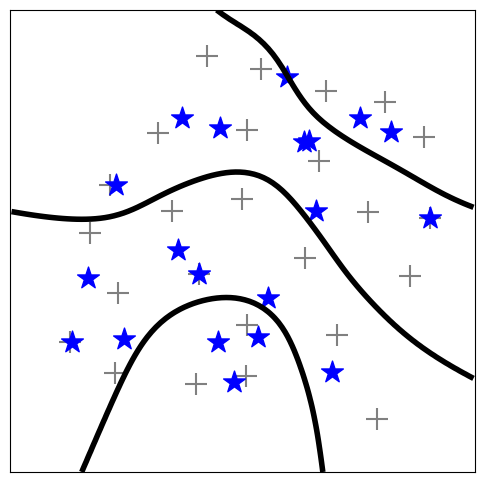

In [9]:
new_data_plot = None
previous_data = None
kernel_hyperparam = []

for i in range(4):
    
    new_data = (tf.gather(train_x, batches[i]).numpy(), tf.gather(train_y, batches[i])[..., None].numpy())  
    
    kernel_hyperparam += m_online.update_with_new_batch(new_data=new_data, train_hyps = not fast_conditioning, 
                                   n_hyp_opt_steps=iterations)

    if new_data_plot is None:
        new_data_plot = (new_data[0], new_data[1])
    else:
        if previous_data is None:
            previous_data = (new_data_plot[0], new_data_plot[1])
        else:
            previous_data = (
                    np.concatenate([previous_data[0], new_data_plot[0]], axis=0),
                    np.concatenate([previous_data[1], new_data_plot[1]], axis=0)
                        )
        
        new_data_plot = (new_data[0], new_data[1])
        
    # Plotting
    pred_mu, pred_var = m_cont.predict_y(Xtest)
    
    Z_opt = m_cont.inducing_variable.Z.numpy().copy()
    if i<3:
        plot_banana(pred_mu, pred_var, pred_mu, Z_opt, new_data_plot, xtest, ytest, vmin=vmin, vmax=vmax, 
                    plot_inducing=False, plot_probability=plot_probability, 
                    plot_colorbar=False, previous_data=previous_data)
    
    else:
        plot_banana(pred_mu, pred_var, pred_mu, Z_opt, new_data_plot, xtest, ytest, vmin=vmin, vmax=vmax, 
                    plot_inducing=False, plot_probability=plot_probability, plot_colorbar=False,
                    previous_data=previous_data)
    
    plot_z_mem(Z_opt, m_online.memory[0].copy(), xtest, ytest, pred_mu)
    

## Hyperparams plot in case of not fast conditioning

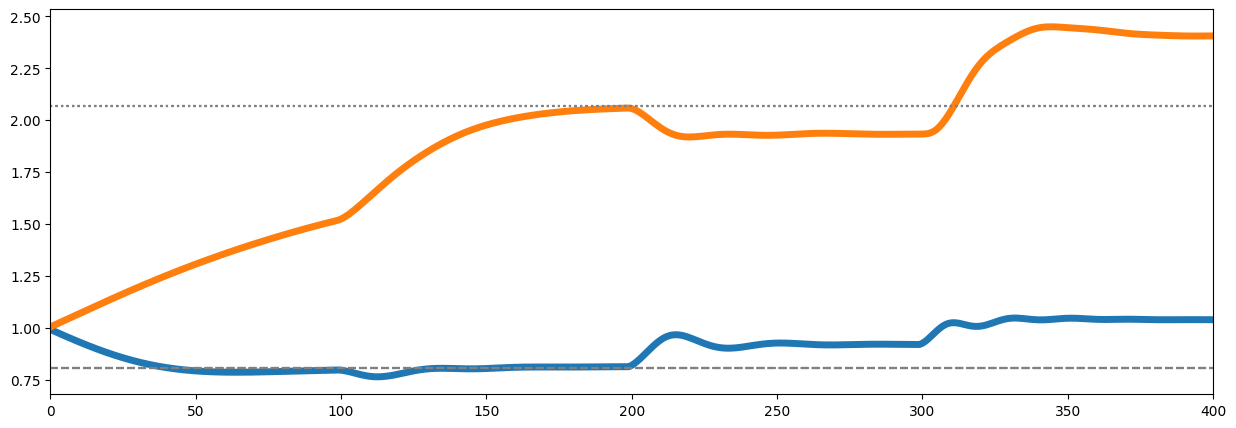

In [10]:
if not fast_conditioning:
    baseline_lengthscale = m_full.kernel.lengthscales.numpy()
    baseline_variance = m_full.kernel.variance.numpy()
    
    kernel_hyperparam_arr = np.array(kernel_hyperparam)
    
    plt.subplots(1, 1, figsize=(15,5))

    plt.plot(kernel_hyperparam_arr[:, 0], linewidth=5.)
    plt.plot(kernel_hyperparam_arr[:, 1], linewidth=5.)

    for i in range(4):
        plt.hlines(baseline_lengthscale, 0, 4000, linestyle="dashed", color="grey")
        plt.hlines(baseline_variance, 0, 4000, linestyle=":", color="grey")

    plt.xlim([0, kernel_hyperparam_arr.shape[0]])

    plt.show()
